<a href="https://colab.research.google.com/github/hyeamykim/Deep_learning_with_TF2/blob/main/LSTM_CNN_for_HumanActivityRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1D CNN for Human Activity Recognotion (HAR)

Reference: https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/

## Data

### Google Drive Loading


In [ ]:
import numpy as np
import pickle as pk
from google.colab import drive
import tensorflow as tf
import os
# drive.mount('/content/gdrive', force_remount=True)

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#!unzip gdrive/My\ Drive/Colab\ Notebooks/DLLab/UCI\ HAR\ Dataset.zip

To suppres the output

In [ ]:
!unzip gdrive/My\ Drive/Colab\ Notebooks/DLLab/UCI\ HAR\ Dataset.zip > /dev/null

### Data Loading

In [ ]:
# import libraries
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

In [ ]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

In [ ]:
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

In [ ]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [ ]:
trainX, trainy, testX, testy = load_dataset() # prints out the shape of trainX, trainy, testX, testy

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


### Data Preprocesing

Normalize the dataset

In [ ]:
# reshape the data to be used for scaler input

trainX = trainX.reshape((-1,128*9))
testX = testX.reshape((-1,128*9))

In [ ]:
# standardize the dataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()

motion_training_scaler = scaler.fit(trainX)
trainX = motion_training_scaler.transform(trainX)
testX = motion_training_scaler.transform(testX)

In [ ]:
# size has to be defined as (batch, n_timesteps, n_features) to be used for the input for neural network
trainX = trainX.reshape((-1,128,9)) 
testX = testX.reshape((-1,128,9))

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

# Model

### LSTM

In [ ]:
from tensorflow.keras.layers import Dense, GRU, SimpleRNN, LSTM, Dropout
from tensorflow.keras import Model as Model_
from tensorflow.keras import regularizers

# define a model structure
class LSTM_Model(Model_):
  def __init__(self): 
    super(LSTM_Model, self).__init__()
    self.lstmLayer = LSTM(units=20, input_shape=(n_timesteps,n_features))
    self.dropoutLayer = Dropout(0.2)
    
    # The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
    #self.gruLayer = GRU(256)
    # The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
    #self.rnnLayer = SimpleRNN(128)

    self.outputLayer = Dense(6, activation='softmax') 
  
  # to use the model 
  def call(self, input_x):
    output = input_x
    output = self.lstmLayer(output)
    output = self.dropoutLayer(output)
    return self.outputLayer(output)

In [ ]:
# optimizer defined with model, regularizer, minibatch, learning rate, and loss
class Optimizer:
  def __init__(self, model, mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam):
    self.model     = model
    self.loss      = loss() #tf.keras.losses.MeanSquaredError()
    self.optimizer = opt(learning_rate = lr)
    self.mb        = mb

    self.train_loss     = tf.keras.metrics.Mean(name='train_loss')
    self.train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

    self.test_loss     = tf.keras.metrics.Mean(name='test_loss')
    self.test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

  
  @tf.function
  def train_step(self, x , y):
    with tf.GradientTape() as tape: # to watch the trainable variables of model and record the operations for performing automatic differentiation
      predictions = model(x)
      loss = self.loss(y, predictions)

    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    self.train_accuracy(y, predictions)
    return loss

  @tf.function
  def test_step(self, x , y):
    predictions = self.model(x)
    loss = self.loss(y, predictions)
    self.test_loss(loss)
    self.test_accuracy(y, predictions)

  def train (self):# for each mini batch, make predictions for train set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.train_ds:
      self.train_step(mbX, mbY)
  
  def test  (self): # for each mini batch, make predictions for test set and calculate loss (which is an average of the loss values in the batch)
    for mbX, mbY in self.test_ds:
      self.test_step(mbX, mbY)    
  
  def run   (self, dataX, dataY, testX, testY, epochs, verbose=2):
    historyTR = []
    historyTS = []
    final_accuracy = 0

    template = '{} {}, {}: {}, {}: {}'
    # generate batches with the shuffled data from train set and from test set, respectively
    self.train_ds = tf.data.Dataset.from_tensor_slices((dataX, dataY)).batch(self.mb)
    self.test_ds  = tf.data.Dataset.from_tensor_slices((testX,testY)).batch(self.mb)
    for i in range(epochs):
      
      self.train ()
    #   print(lossTR)
      self.test  ()
      # if verbose, print loss values for each epoch
      if verbose > 0:
        print(template.format("epoch: ", i+1,
                      " TRAIN LOSS: %.4f " % (self.train_loss.result()),
                      " TEST LOSS: %.4f "  % (self.test_loss.result()),
                      " TRAIN ACC: %.4f "  % (self.train_accuracy.result()*100),
                      " TEST ACC: %.4f "   % (self.test_accuracy.result()*100)))
      
      temp = '{}'

      # append loss values for train and test loss histories
      historyTR.append(float(temp.format(self.train_loss.result())))
      historyTS.append(float(temp.format(self.test_loss.result() )))

      final_accuracy = self.test_accuracy.result()*100

      # has to reset states for each epoch
      self.train_loss.reset_states()
      self.train_accuracy.reset_states()
      self.test_loss.reset_states()
      self.test_accuracy.reset_states()
    return final_accuracy, historyTR, historyTS # train loss values and test loss values

In [ ]:
# initiate a model instance
model  = LSTM_Model()

# initiate an optimzer instance to run
opt    = Optimizer (model,  mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam)
# or just: $ opt    = Optimizer (model)

# get train and test loss values after running the optimizer
acc, tr, ts = opt.run (trainX, trainy, testX, testy, 25, verbose=1)

epoch:  1,  TRAIN LOSS: 1.4694 :  TEST LOSS: 1.2887 ,  TRAIN ACC: 49.8096 :  TEST ACC: 54.1568 
epoch:  2,  TRAIN LOSS: 1.0654 :  TEST LOSS: 0.9920 ,  TRAIN ACC: 62.7040 :  TEST ACC: 62.5721 
epoch:  3,  TRAIN LOSS: 0.8470 :  TEST LOSS: 0.8711 ,  TRAIN ACC: 66.7573 :  TEST ACC: 65.2528 
epoch:  4,  TRAIN LOSS: 0.7580 :  TEST LOSS: 0.7848 ,  TRAIN ACC: 69.8857 :  TEST ACC: 68.7818 
epoch:  5,  TRAIN LOSS: 0.6867 :  TEST LOSS: 0.7246 ,  TRAIN ACC: 74.2519 :  TEST ACC: 73.0913 
epoch:  6,  TRAIN LOSS: 0.6171 :  TEST LOSS: 0.6825 ,  TRAIN ACC: 78.8221 :  TEST ACC: 77.5704 
epoch:  7,  TRAIN LOSS: 0.5554 :  TEST LOSS: 0.5945 ,  TRAIN ACC: 82.5898 :  TEST ACC: 80.5226 
epoch:  8,  TRAIN LOSS: 0.4830 :  TEST LOSS: 0.5259 ,  TRAIN ACC: 84.9021 :  TEST ACC: 82.9997 
epoch:  9,  TRAIN LOSS: 0.4065 :  TEST LOSS: 0.5046 ,  TRAIN ACC: 87.3096 :  TEST ACC: 83.1015 
epoch:  10,  TRAIN LOSS: 0.3742 :  TEST LOSS: 0.4963 ,  TRAIN ACC: 87.3776 :  TEST ACC: 83.1354 
epoch:  11,  TRAIN LOSS: 0.3590 :  TEST

3.2.2


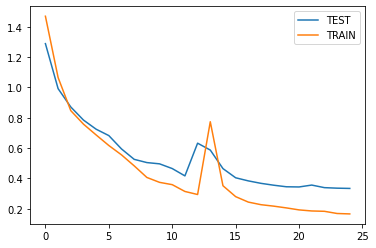

In [ ]:
# print train and test loss over epoch
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
plt.plot(ts, label='TEST')
plt.plot(tr, label='TRAIN')
plt.legend()
plt.show()

#### Model Evaluation

Repeat experiments to validate the model evaluation

In [ ]:
# summarize scores
def summarize_results(scores):
  print(scores)
  m, s = mean(scores), std(scores)
  print('Accuracy: %.3f%% (+/-%.3f' %(m,s))

In [ ]:
# run an experiment
def run_experiment(repeats=10):

  #trainX, trainy, testX, testy = load_dataset()

  # repeat experiment
  scores = list()
  for r in range(repeats):
    score, tr, ts = opt.run(trainX, trainy, testX, testy, 25, verbose=0)
    print('>#%d: %3.f' % (r+1, score))
    scores.append(score)

  # summarize results
  summarize_results(scores)

In [ ]:
run_experiment()

>#1:  89
>#2:  90
>#3:  89
>#4:  91
>#5:  90
>#6:  90
>#7:  91
>#8:  91
>#9:  90
>#10:  91
[<tf.Tensor: shape=(), dtype=float32, numpy=89.3451>, <tf.Tensor: shape=(), dtype=float32, numpy=89.786224>, <tf.Tensor: shape=(), dtype=float32, numpy=89.07363>, <tf.Tensor: shape=(), dtype=float32, numpy=91.109604>, <tf.Tensor: shape=(), dtype=float32, numpy=90.12555>, <tf.Tensor: shape=(), dtype=float32, numpy=89.58263>, <tf.Tensor: shape=(), dtype=float32, numpy=91.07567>, <tf.Tensor: shape=(), dtype=float32, numpy=90.634544>, <tf.Tensor: shape=(), dtype=float32, numpy=89.58263>, <tf.Tensor: shape=(), dtype=float32, numpy=90.66847>]
Accuracy: 90.098% (+/-0.696


### CNN

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Embedding, MaxPool1D, Dense
from tensorflow.keras import Model as Model_
from tensorflow.keras import regularizers

# define a model structure
class CNN_Model(Model_):
  def __init__(self): 
    super(CNN_Model, self).__init__()
    self.conv1 = Conv1D(32, 3, activation='relu')
    self.maxpool = MaxPool1D()
    self.conv2 = Conv1D(32, 3, activation='relu')
    self.globalmaxpool = GlobalMaxPooling1D()  
    #self.dropout = Dropout(0.2)
    self.outputLayer = Dense(6, activation='softmax')

  # to use the model 
  def call(self, input_x):
    output = input_x
    output = self.conv1(output)
    output = self.maxpool(output)
    output = self.conv2(output)
    output = self.globalmaxpool(output)
    #output = self.dropoutLayer(output)
    return self.outputLayer(output)

In [ ]:
# initiate a model instance
model  = CNN_Model()

# initiate an optimzer instance to run
opt    = Optimizer (model,  mb = 128, lr = 0.001, loss = tf.keras.losses.CategoricalCrossentropy, opt=tf.keras.optimizers.Adam)
# or just: $ opt    = Optimizer (model)

# get train and test loss values after running the optimizer
acc, tr, ts = opt.run (trainX, trainy, testX, testy, 25, verbose=1)

epoch:  1,  TRAIN LOSS: 1.2891 :  TEST LOSS: 0.9498 ,  TRAIN ACC: 50.0680 :  TEST ACC: 78.0455 
epoch:  2,  TRAIN LOSS: 0.7134 :  TEST LOSS: 0.6420 ,  TRAIN ACC: 86.6567 :  TEST ACC: 83.5426 
epoch:  3,  TRAIN LOSS: 0.4558 :  TEST LOSS: 0.4728 ,  TRAIN ACC: 90.6148 :  TEST ACC: 86.4269 
epoch:  4,  TRAIN LOSS: 0.3072 :  TEST LOSS: 0.3778 ,  TRAIN ACC: 92.2198 :  TEST ACC: 88.2253 
epoch:  5,  TRAIN LOSS: 0.2336 :  TEST LOSS: 0.3318 ,  TRAIN ACC: 93.0359 :  TEST ACC: 88.1235 
epoch:  6,  TRAIN LOSS: 0.1939 :  TEST LOSS: 0.3087 ,  TRAIN ACC: 93.3079 :  TEST ACC: 88.3610 
epoch:  7,  TRAIN LOSS: 0.1707 :  TEST LOSS: 0.2930 ,  TRAIN ACC: 93.5120 :  TEST ACC: 88.5307 
epoch:  8,  TRAIN LOSS: 0.1560 :  TEST LOSS: 0.2819 ,  TRAIN ACC: 93.7160 :  TEST ACC: 89.0736 
epoch:  9,  TRAIN LOSS: 0.1455 :  TEST LOSS: 0.2727 ,  TRAIN ACC: 93.8384 :  TEST ACC: 89.3451 
epoch:  10,  TRAIN LOSS: 0.1380 :  TEST LOSS: 0.2647 ,  TRAIN ACC: 94.0288 :  TEST ACC: 89.6505 
epoch:  11,  TRAIN LOSS: 0.1322 :  TEST

3.2.2


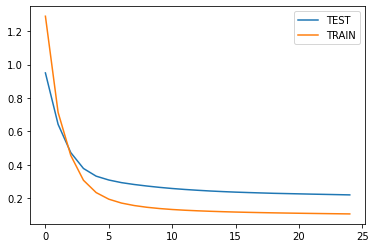

In [ ]:
# print train and test loss over epoch
import matplotlib.pyplot as plt
import matplotlib
print(matplotlib.__version__)
plt.plot(ts, label='TEST')
plt.plot(tr, label='TRAIN')
plt.legend()
plt.show()

#### Model Evaluation

In [ ]:
run_experiment()

>#1:  93
>#2:  93
>#3:  93
>#4:  92
>#5:  92
>#6:  93
>#7:  93
>#8:  93
>#9:  92
>#10:  92
[<tf.Tensor: shape=(), dtype=float32, numpy=92.67051>, <tf.Tensor: shape=(), dtype=float32, numpy=93.41704>, <tf.Tensor: shape=(), dtype=float32, numpy=92.73838>, <tf.Tensor: shape=(), dtype=float32, numpy=91.82219>, <tf.Tensor: shape=(), dtype=float32, numpy=91.58466>, <tf.Tensor: shape=(), dtype=float32, numpy=92.77231>, <tf.Tensor: shape=(), dtype=float32, numpy=92.602646>, <tf.Tensor: shape=(), dtype=float32, numpy=92.53478>, <tf.Tensor: shape=(), dtype=float32, numpy=92.19545>, <tf.Tensor: shape=(), dtype=float32, numpy=91.82219>]
Accuracy: 92.416% (+/-0.528
